In [1]:
from funcsMain import *
np.set_printoptions(linewidth=np.inf) # prevents numpy from shrinking the visual output

# Using PySINDy to identify 2nd order differential systems

In the first underlying cell, the necessary imports and definitions are made.

(NB. Please refer to `funcsMain` for all imports)

In [2]:
p = np.load('3_body/JSSpos_1mil.npy')
a = np.load('3_body/JSSacc_1mil.npy')

## Model identification

The following cell includes a writeout of the functions, model, optimization and model identification. This is also found in `sindy()` which is a part of `funcsMain`. 

To begin with the necessary functions are written up. As mentioned in the report this notebook belongs to, the functions are build from already established theory. The functions is then put into `CustomLibrary` which is a `pysindy` function. 

Next the optimizer is set. Here `STLSQ` is choosen because of its sparsity and is given a threshold of 1e-2. 

After the time array has been defined, the model is build. The model takes starting point in `ps.SINDy` but are given the custom library and the optimizer. 

The model is then fitted with given restrictions. Here we're looking for the accelerations, hence setting `x_dot=a`. 

After fitting the model it is printed with a custom left hand side and the coefficients are defined and printed. 

In [3]:
functions = [lambda x0, y0, x1, y1, x2, y2: (x1-x0)/((x1-x0)**2+(y1-y0)**2)**(3/2),
             lambda x0, y0, x1, y1, x2, y2: (y1-y0)/((x1-x0)**2+(y1-y0)**2)**(3/2),
             lambda x0, y0, x1, y1, x2, y2: (x2-x0)/((x2-x0)**2+(y2-y0)**2)**(3/2),
             lambda x0, y0, x1, y1, x2, y2: (y2-y0)/((x2-x0)**2+(y2-y0)**2)**(3/2),
             lambda x0, y0, x1, y1, x2, y2: (x2-x1)/((x2-x1)**2+(y2-y1)**2)**(3/2), 
             lambda x0, y0, x1, y1, x2, y2: (y2-y1)/((x2-x1)**2+(y2-y1)**2)**(3/2)]
    
lib_custom = CustomLibrary(library_functions=functions)
optimizer = ps.STLSQ(threshold=1e-2)

t = np.arange(0, p.shape[0], 1)

model = ps.SINDy( 
        feature_library = lib_custom, 
        optimizer=optimizer)

model.fit(p, t=t, x_dot=a)
model.print(lhs=["x1''","y1''","x2''","y2''","x3''","y3''"])
coef = model.coefficients()
print(coef)

x1'' = 0.038 f0(x0,x1,x2,x3,x4,x5) + 0.011 f2(x0,x1,x2,x3,x4,x5)
y1'' = 0.038 f1(x0,x1,x2,x3,x4,x5) + 0.011 f3(x0,x1,x2,x3,x4,x5)
x2'' = -39.480 f0(x0,x1,x2,x3,x4,x5) + 0.011 f4(x0,x1,x2,x3,x4,x5)
y2'' = -39.480 f1(x0,x1,x2,x3,x4,x5) + 0.011 f5(x0,x1,x2,x3,x4,x5)
x3'' = -39.480 f2(x0,x1,x2,x3,x4,x5) + -0.038 f4(x0,x1,x2,x3,x4,x5)
y3'' = -39.480 f3(x0,x1,x2,x3,x4,x5) + -0.038 f5(x0,x1,x2,x3,x4,x5)
[[ 3.76859355e-02  0.00000000e+00  1.12835590e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.76859415e-02  0.00000000e+00  1.12835608e-02  0.00000000e+00  0.00000000e+00]
 [-3.94796994e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12761871e-02  0.00000000e+00]
 [ 0.00000000e+00 -3.94797057e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12762060e-02]
 [ 0.00000000e+00  0.00000000e+00 -3.94796999e+01  0.00000000e+00 -3.76884303e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.94797056e+01  0.00000000e+00 -3.76854471e-02]]


## Data analysis

The following cells will have the data analysis code. 

The main part of the analysis revolves around calculating the mass by the interaction between Jupiter and Saturn. This can be done by dividing `coef` with the universal gravitational constant G and choosing the values where the bodies interact with one another. G will be set to `= 39,4797` since that is the number of significant digits used in the report. After calculating the mass, it can be compared to the real values. The real values of Jupiters and Saturns mass is defined as `jTrue` and `sTrue`. The comparison is done by running the masses through the custom error function `err`. 

Next the functions found in `functions` together with `p` and `coef` are written such that the accelerations can be calculated. The accelerations will be used to plot the data and by that be able to compare the results. 

In [4]:
G = 39.4797
mEst = coef/G
print(mEst)

def err(aTrue, aEst): # also in funcsMain
    error = (np.mean((aEst-aTrue)**2))/(np.mean(aTrue**2))
    return error

jTrue = 9.54564884e-04 # mass in Solar masses
sTrue = 2.85806241e-04

jx = err(jTrue, -mEst[4, 4]) # given '-' since masses can't be negative
jy = err(jTrue, -mEst[5, 5])
print(f'Error in Jupiters mass {np.mean([jx, jy])}')

sx = err(sTrue, mEst[2, 4]) 
sy = err(sTrue, mEst[3, 5]) 
print(f'Error in Saturns mass {np.mean([sx, sy])}')

[[ 9.54564891e-04  0.00000000e+00  2.85806604e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.54565042e-04  0.00000000e+00  2.85806650e-04  0.00000000e+00  0.00000000e+00]
 [-9.99999986e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.85619878e-04  0.00000000e+00]
 [ 0.00000000e+00 -1.00000014e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.85620356e-04]
 [ 0.00000000e+00  0.00000000e+00 -9.99999997e-01  0.00000000e+00 -9.54628082e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000014e+00  0.00000000e+00 -9.54552519e-04]]
Error in Jupiters mass 2.2755310134121453e-09
Error in Saturns mass 4.240938914805546e-07


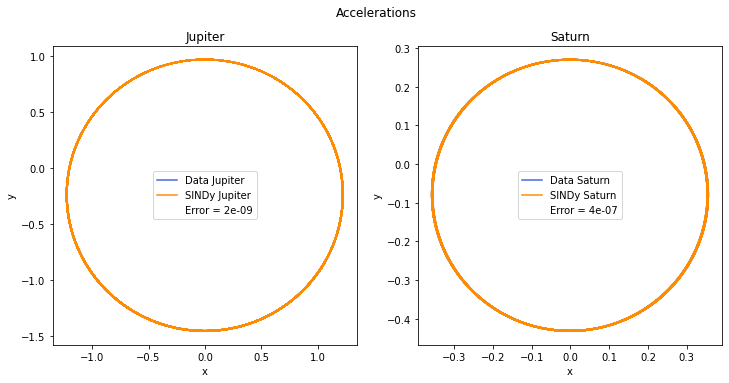

In [11]:
F0 = (p[:, 2]-p[:, 0])/((p[:, 2]-p[:, 0])**2+(p[:, 3]-p[:, 1])**2)**(3/2)
F1 = (p[:, 3]-p[:, 1])/((p[:, 2]-p[:, 0])**2+(p[:, 3]-p[:, 1])**2)**(3/2)
F2 = (p[:, 4]-p[:, 0])/((p[:, 4]-p[:, 0])**2+(p[:, 5]-p[:, 1])**2)**(3/2)
F3 = (p[:, 5]-p[:, 1])/((p[:, 4]-p[:, 0])**2+(p[:, 5]-p[:, 1])**2)**(3/2)
F4 = (p[:, 4]-p[:, 2])/((p[:, 4]-p[:, 2])**2+(p[:, 5]-p[:, 3])**2)**(3/2)
F5 = (p[:, 5]-p[:, 3])/((p[:, 4]-p[:, 2])**2+(p[:, 5]-p[:, 3])**2)**(3/2)
F = np.array([F0, F1, F2, F3, F4, F5])
aModel = np.dot(coef, F)

err0 = str(round(np.mean([jx, jy]), 9)) # making errors into strings
err1 = str(round(np.mean([sx, sy]), 7))

plot2(a[:, 2], a[:, 3], 'Jupiter', a[:, 4], a[:, 5], 'Saturn', aModel[2, :], aModel[3, :], aModel[4, :], aModel[5, :], err0, err1)
#plt.savefig('aComp.png') # saves the figure in the current directory as a png

## Practical use

The notebook has until now explained everything that is needed to know about the use of the SINDy algorithm, but everything has been made into functions which can be found in `funcsMain`. The following cells will do the same as the previous, but now using the functions instead. Mainly the `sindy()` function and the `f_3` functions will be focused upon. 

In [7]:
sindy(3, p, a, 1e-2)

x1'' = 0.038 f0(x0,x1,x2,x3,x4,x5) + 0.011 f2(x0,x1,x2,x3,x4,x5)
y1'' = 0.038 f1(x0,x1,x2,x3,x4,x5) + 0.011 f3(x0,x1,x2,x3,x4,x5)
x2'' = -39.480 f0(x0,x1,x2,x3,x4,x5) + 0.011 f4(x0,x1,x2,x3,x4,x5)
y2'' = -39.480 f1(x0,x1,x2,x3,x4,x5) + 0.011 f5(x0,x1,x2,x3,x4,x5)
x3'' = -39.480 f2(x0,x1,x2,x3,x4,x5) + -0.038 f4(x0,x1,x2,x3,x4,x5)
y3'' = -39.480 f3(x0,x1,x2,x3,x4,x5) + -0.038 f5(x0,x1,x2,x3,x4,x5)
[[ 3.76859355e-02  0.00000000e+00  1.12835590e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.76859415e-02  0.00000000e+00  1.12835608e-02  0.00000000e+00  0.00000000e+00]
 [-3.94796994e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12761871e-02  0.00000000e+00]
 [ 0.00000000e+00 -3.94797057e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12762060e-02]
 [ 0.00000000e+00  0.00000000e+00 -3.94796999e+01  0.00000000e+00 -3.76884303e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.94797056e+01  0.00000000e+00 -3.76854471e-02]]


array([[ 3.76859355e-02,  0.00000000e+00,  1.12835590e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.76859415e-02,  0.00000000e+00,  1.12835608e-02,  0.00000000e+00,  0.00000000e+00],
       [-3.94796994e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.12761871e-02,  0.00000000e+00],
       [ 0.00000000e+00, -3.94797057e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.12762060e-02],
       [ 0.00000000e+00,  0.00000000e+00, -3.94796999e+01,  0.00000000e+00, -3.76884303e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.94797056e+01,  0.00000000e+00, -3.76854471e-02]])

In [9]:
f_3(p, coef)
# the plotting function can also be inserted here

array([[ 2.84515999e-04,  2.84480923e-04,  2.84445846e-04, ...,  1.11046604e-03,  1.11045911e-03,  1.11045218e-03],
       [-9.59819347e-04, -9.59828240e-04, -9.59837133e-04, ...,  4.74813014e-05,  4.74263907e-05,  4.73714813e-05],
       [-3.23115640e-01, -3.23080037e-01, -3.23044434e-01, ..., -1.22232995e+00, -1.22232378e+00, -1.22231761e+00],
       [ 9.27459447e-01,  9.27469029e-01,  9.27478610e-01, ..., -1.12692473e-01, -1.12634223e-01, -1.12575974e-01],
       [ 8.36892481e-02,  8.36930659e-02,  8.36968837e-02, ...,  1.97081712e-01,  1.97085357e-01,  1.97089001e-01],
       [ 2.60662915e-01,  2.60662029e-01,  2.60661142e-01, ...,  2.10250535e-01,  2.10248111e-01,  2.10245687e-01]])